In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from cPickle import load
from glob import glob
import os
import os.path as osp
import seaborn as sns

In [51]:
PARENT_FOLDER = '/data/shared/bvFTD/Machine_Learning'
RESULTS_FOLDER = sorted(glob(osp.join(PARENT_FOLDER, 'results_ftr_sel_ftd*_no_Cov')))
NUM_ITER = 2000

In [50]:
N_RESULTS = len(RESULTS_FOLDER)

['/data/shared/bvFTD/Machine_Learning/results_ftr_sel_ftd_neurol_no_Cov', '/data/shared/bvFTD/Machine_Learning/results_ftr_sel_ftd_psych_no_Cov', '/data/shared/bvFTD/Machine_Learning/results_ftr_sel_ftd_rest_no_Cov']


In [52]:
def get_last_part_filename(file_path):
    return os.path.basename(os.path.normpath(file_path)).split('ftr_sel_')[1]

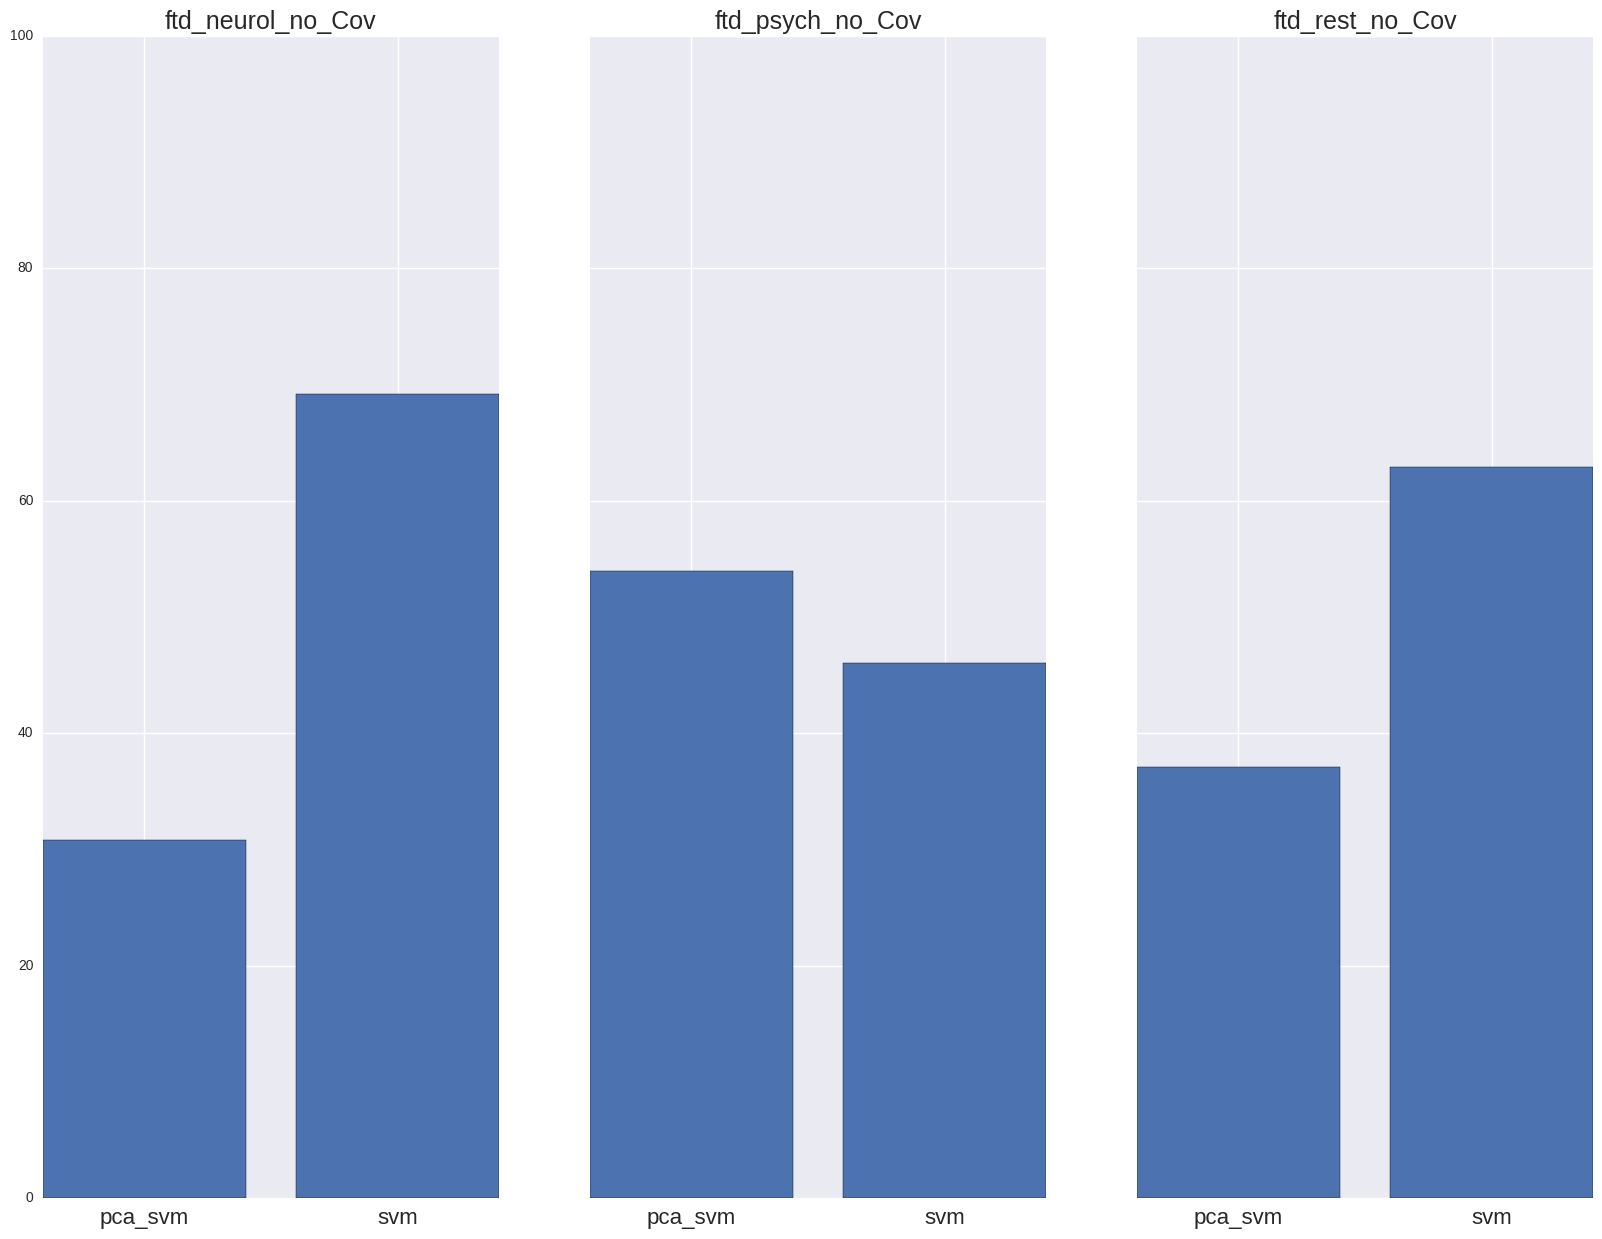

In [61]:
fig, ax = plt.subplots(1, N_RESULTS, sharey=True, figsize=(20, 15))
ax = ax.ravel()

for i in xrange(len(RESULTS_FOLDER)):
    with open(osp.join(RESULTS_FOLDER[i], 'best_model_labels.pkl'), 'rb') as f:
        best_model_labels = load(f)
    best_models_array = np.array(best_model_labels)   
    n_iters = float(len(best_models_array))
    unique_elems, counts = np.unique(best_models_array, return_counts=True)
    elems = counts/n_iters*100
    ax[i].set_ylim([0, 100])
    ax[i].bar([0, 1], elems, align='center', tick_label=unique_elems)
    ax[i].set_title('{}'.format(get_last_part_filename(RESULTS_FOLDER[i])), fontsize=18)
    ax[i].set_xticklabels(unique_elems, fontsize=16)

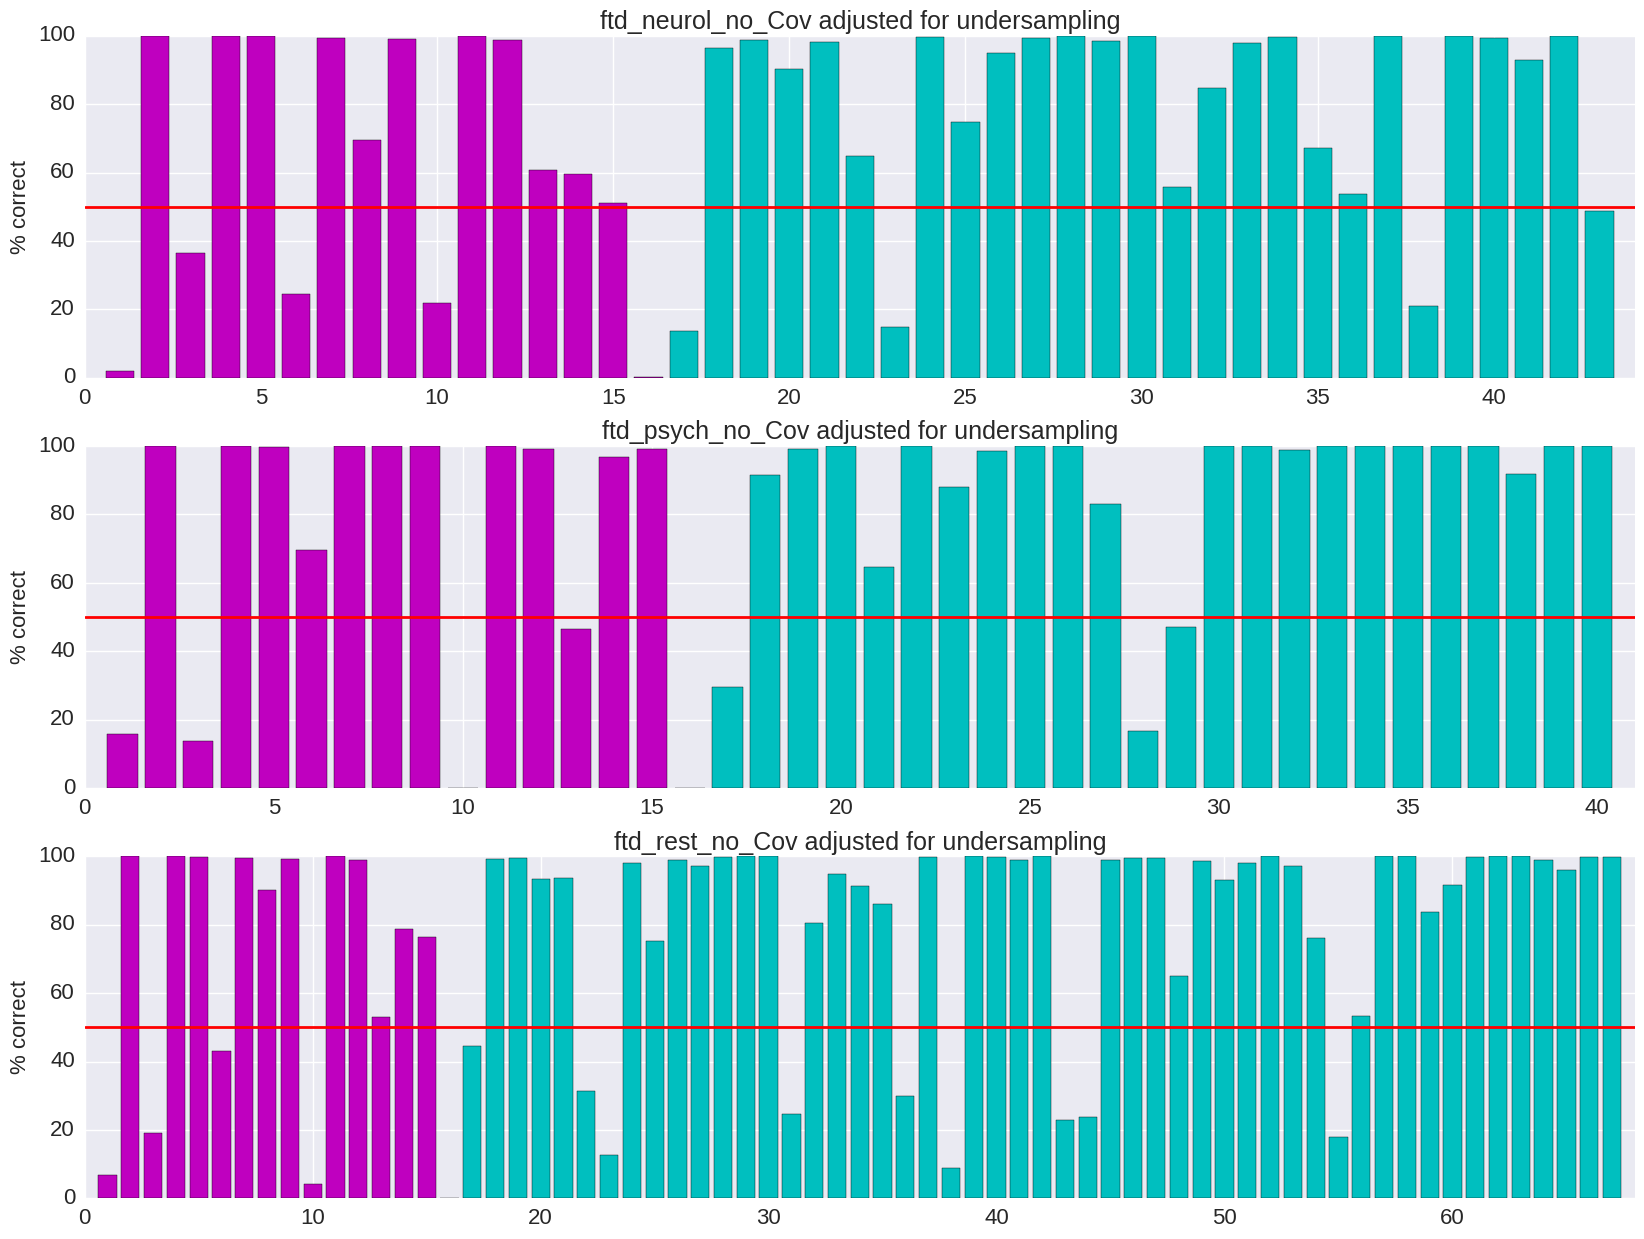

In [62]:
threshold_correct = 0.5
n_ftd = 16

fig, ax = plt.subplots(N_RESULTS, 1, sharey=True, figsize=(20, 15))
ax = ax.ravel()

for i in xrange(len(RESULTS_FOLDER)):
    pred = np.load(osp.join(RESULTS_FOLDER[i], 'predictions.npy')).astype(np.int)
    y_true = np.concatenate((np.ones(n_ftd), np.zeros(pred.shape[0] - n_ftd))).astype(np.int)
    correct_pred = (pred == y_true[:, np.newaxis]).sum(axis=1)
    threshold = (pred.shape[1] - (pred == -1).sum(axis=1, dtype=np.float))
    correct_pred_perc = correct_pred / threshold * 100
    id_ftd = np.arange(1, n_ftd + 1)
    id_other = np.arange(n_ftd + 1, pred.shape[0]+ 1)
    ax[i].axhline(y=50, color='r', linewidth=2)
    ax[i].bar(id_ftd, correct_pred_perc[:n_ftd], align='center', color='m')
    ax[i].bar(id_other, correct_pred_perc[n_ftd:], align='center', color='c')    
    ax[i].set_title('{} adjusted for undersampling'.format(get_last_part_filename(RESULTS_FOLDER[i])),
                   fontsize=18)
    ax[i].set_ylabel('% correct', fontsize=16)
    ax[i].tick_params(axis='both', labelsize=16)
    ax[i].set_xlim((0, id_other.max() + 1))

In [55]:
tmp = np.load(osp.join(RESULTS_FOLDER[0], 'performance_metrics.npz'))
metrics = tmp['metrics']
metrics_labels = tmp['metrics_labels']

In [56]:
metrics_labels

array(['accuracy', 'balanced_accuracy', 'AUC', 'F1', 'recall', 'precision',
       'sensitivity', 'specificity', 'positive_predictive_value'], 
      dtype='|S25')

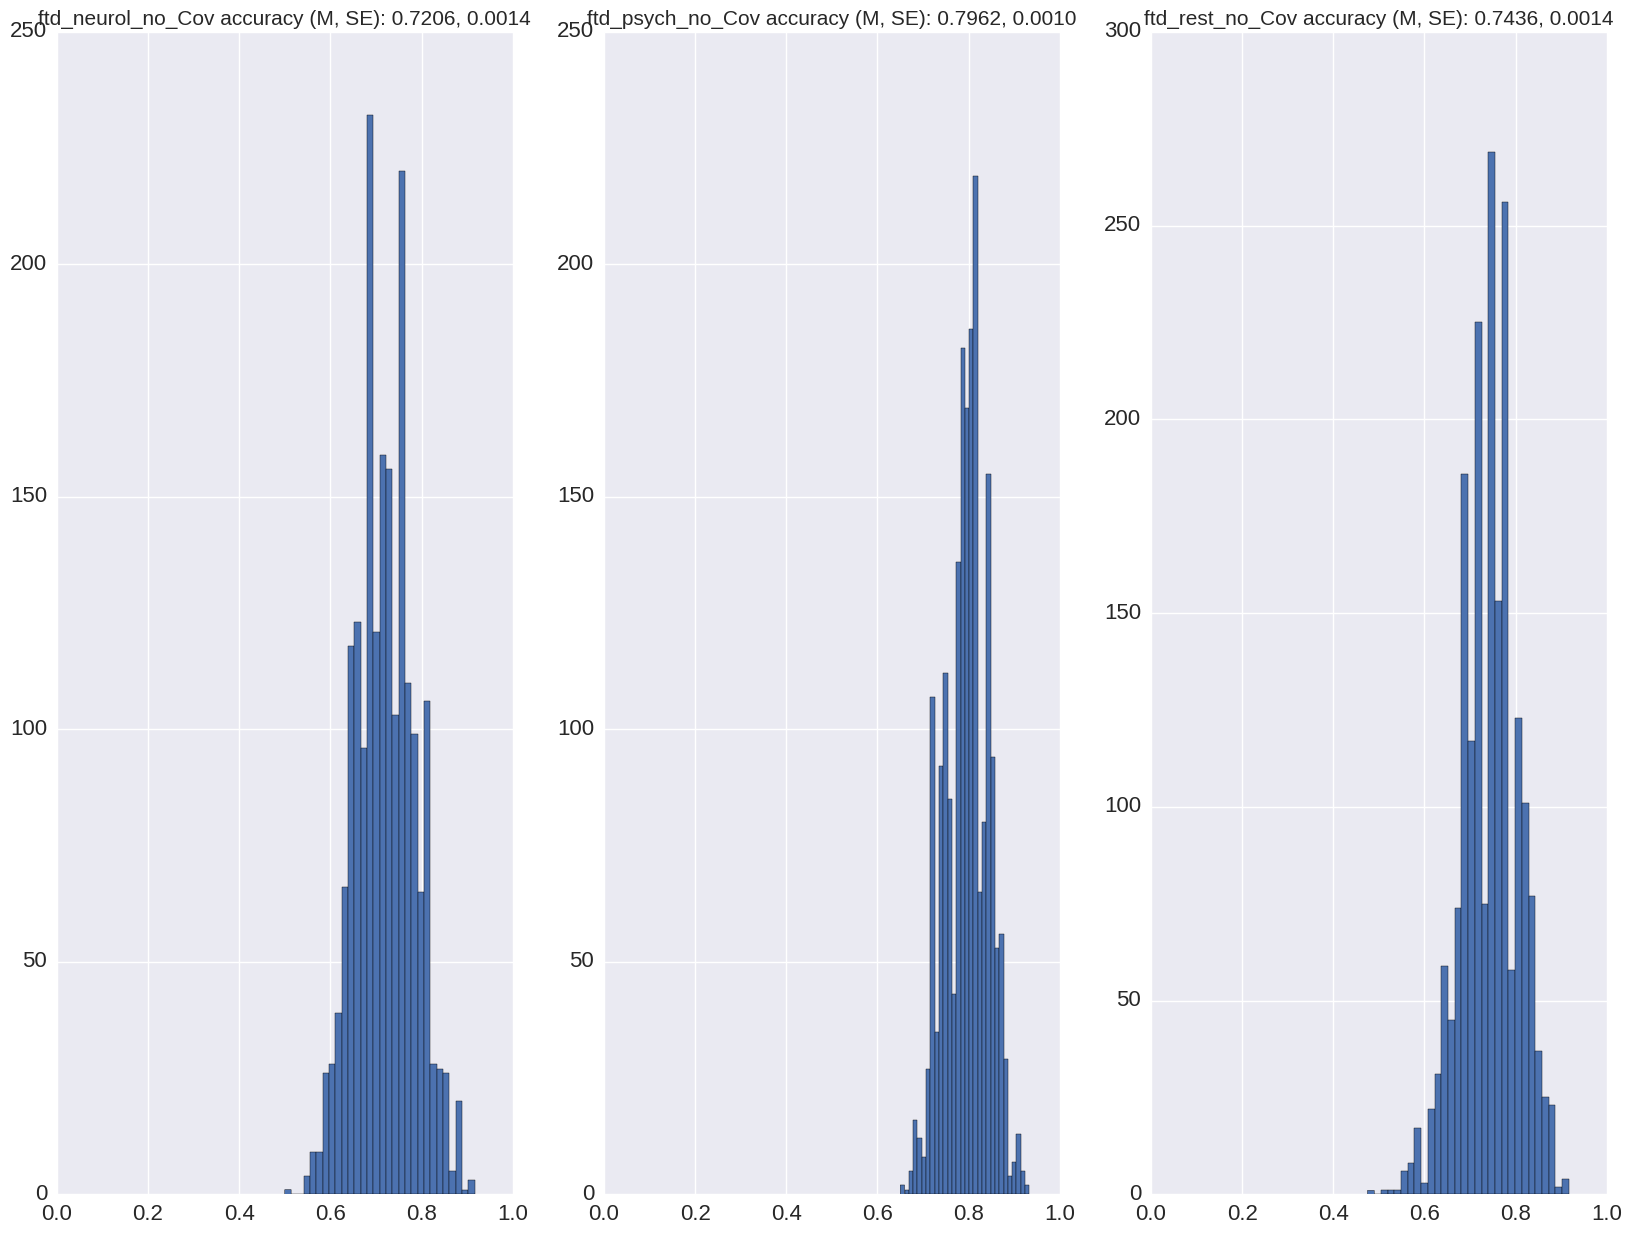

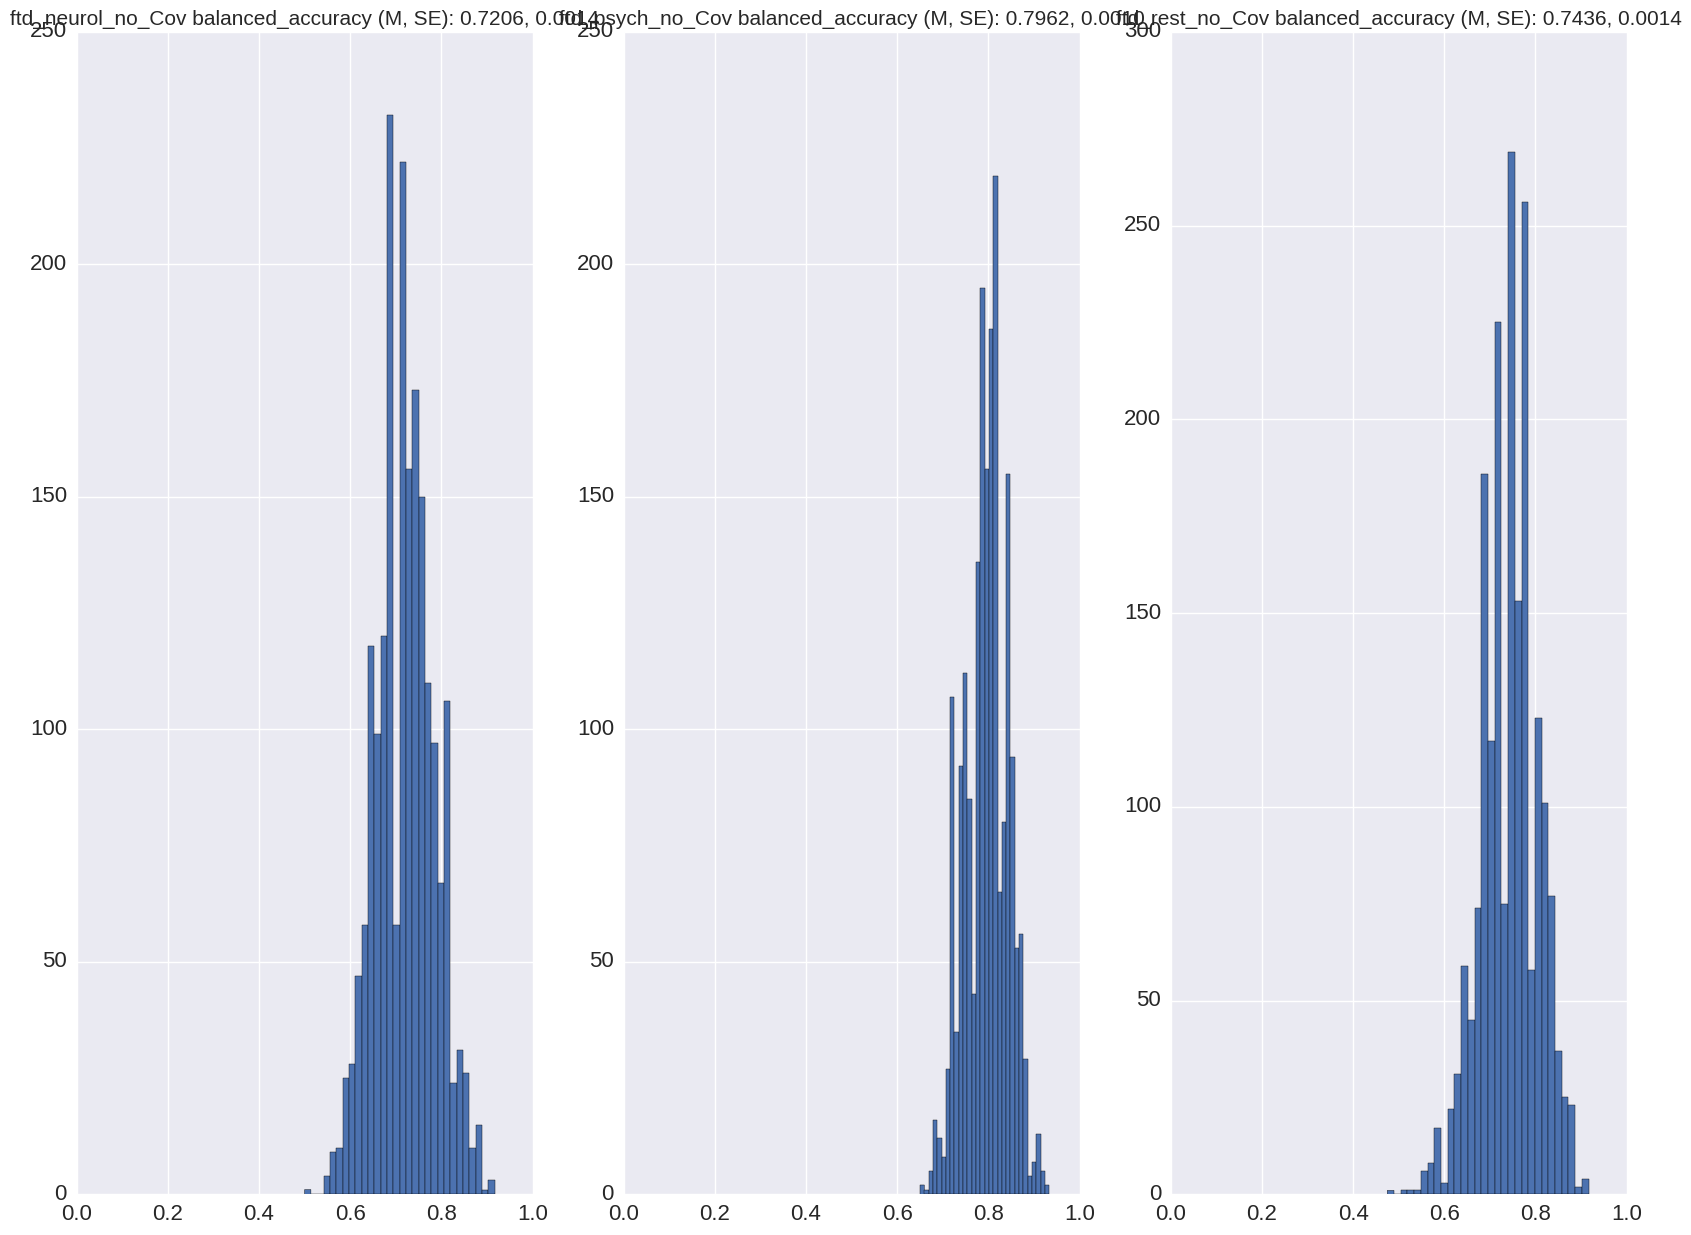

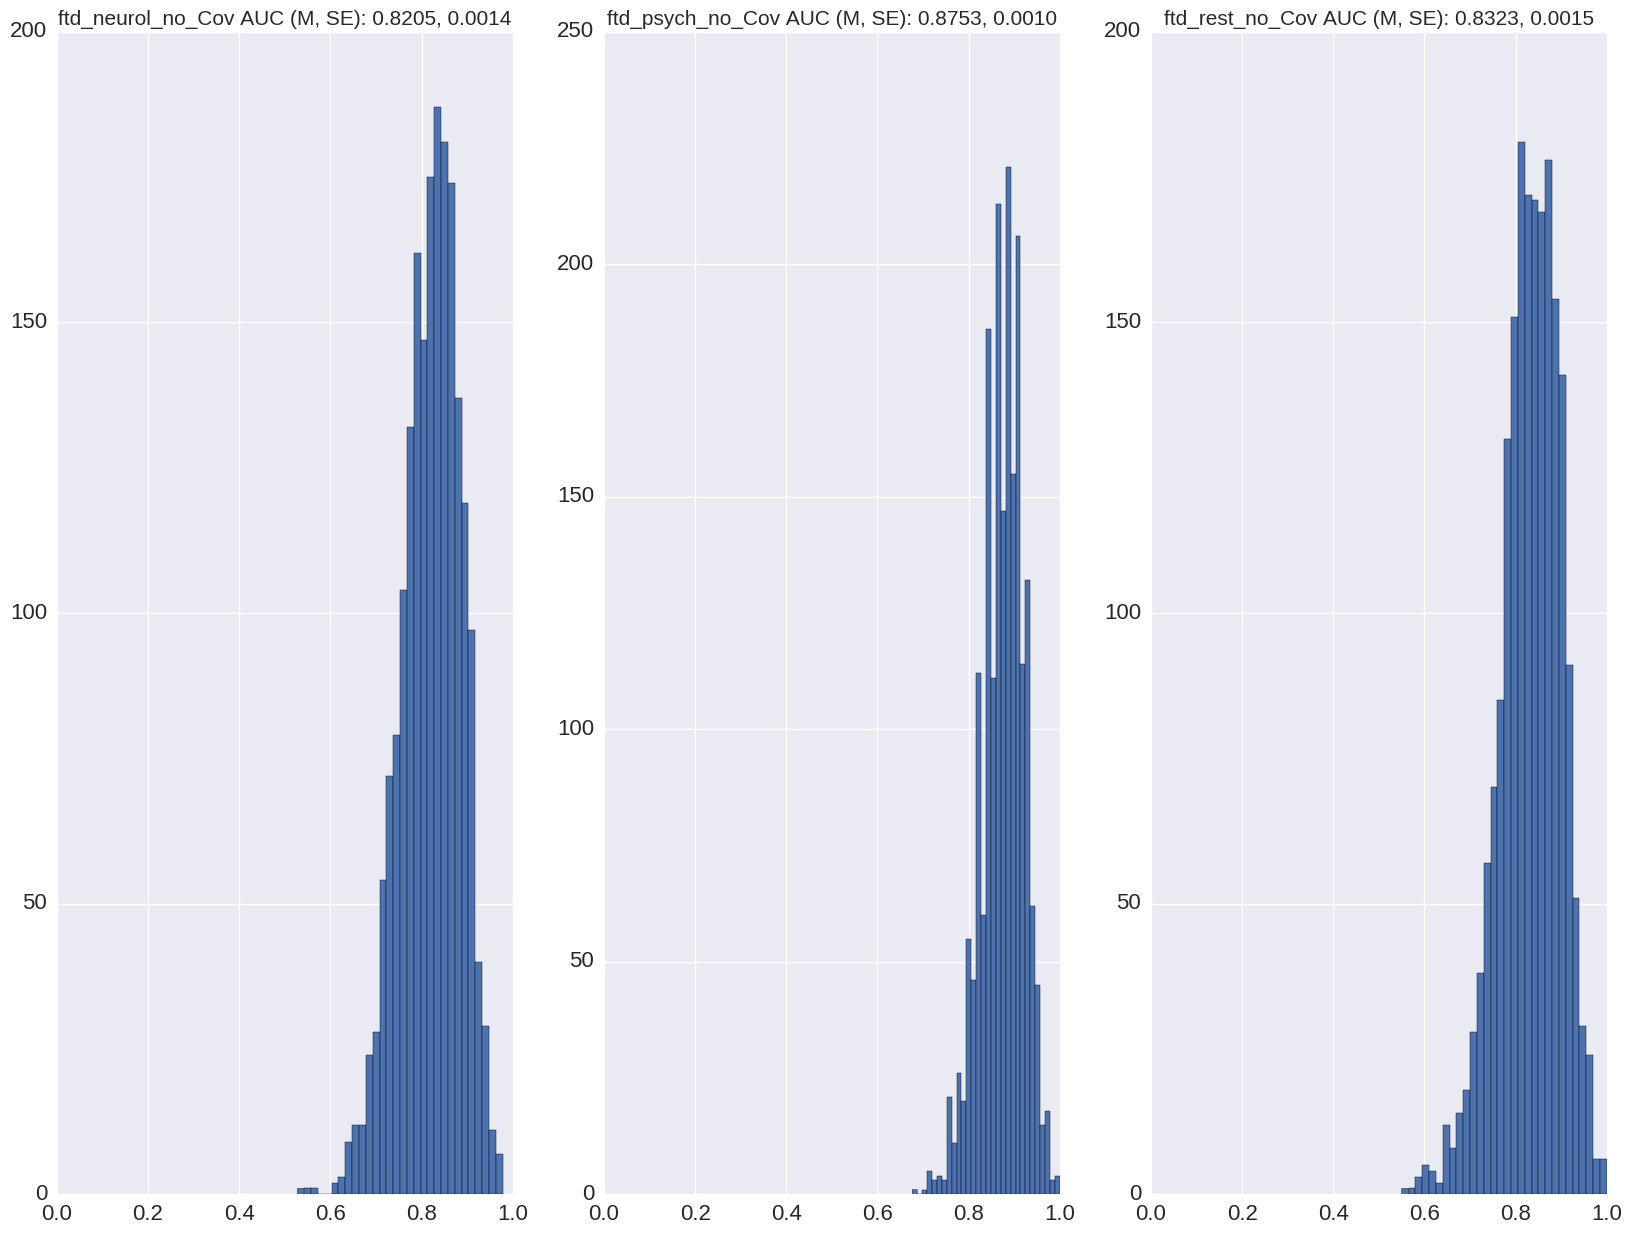

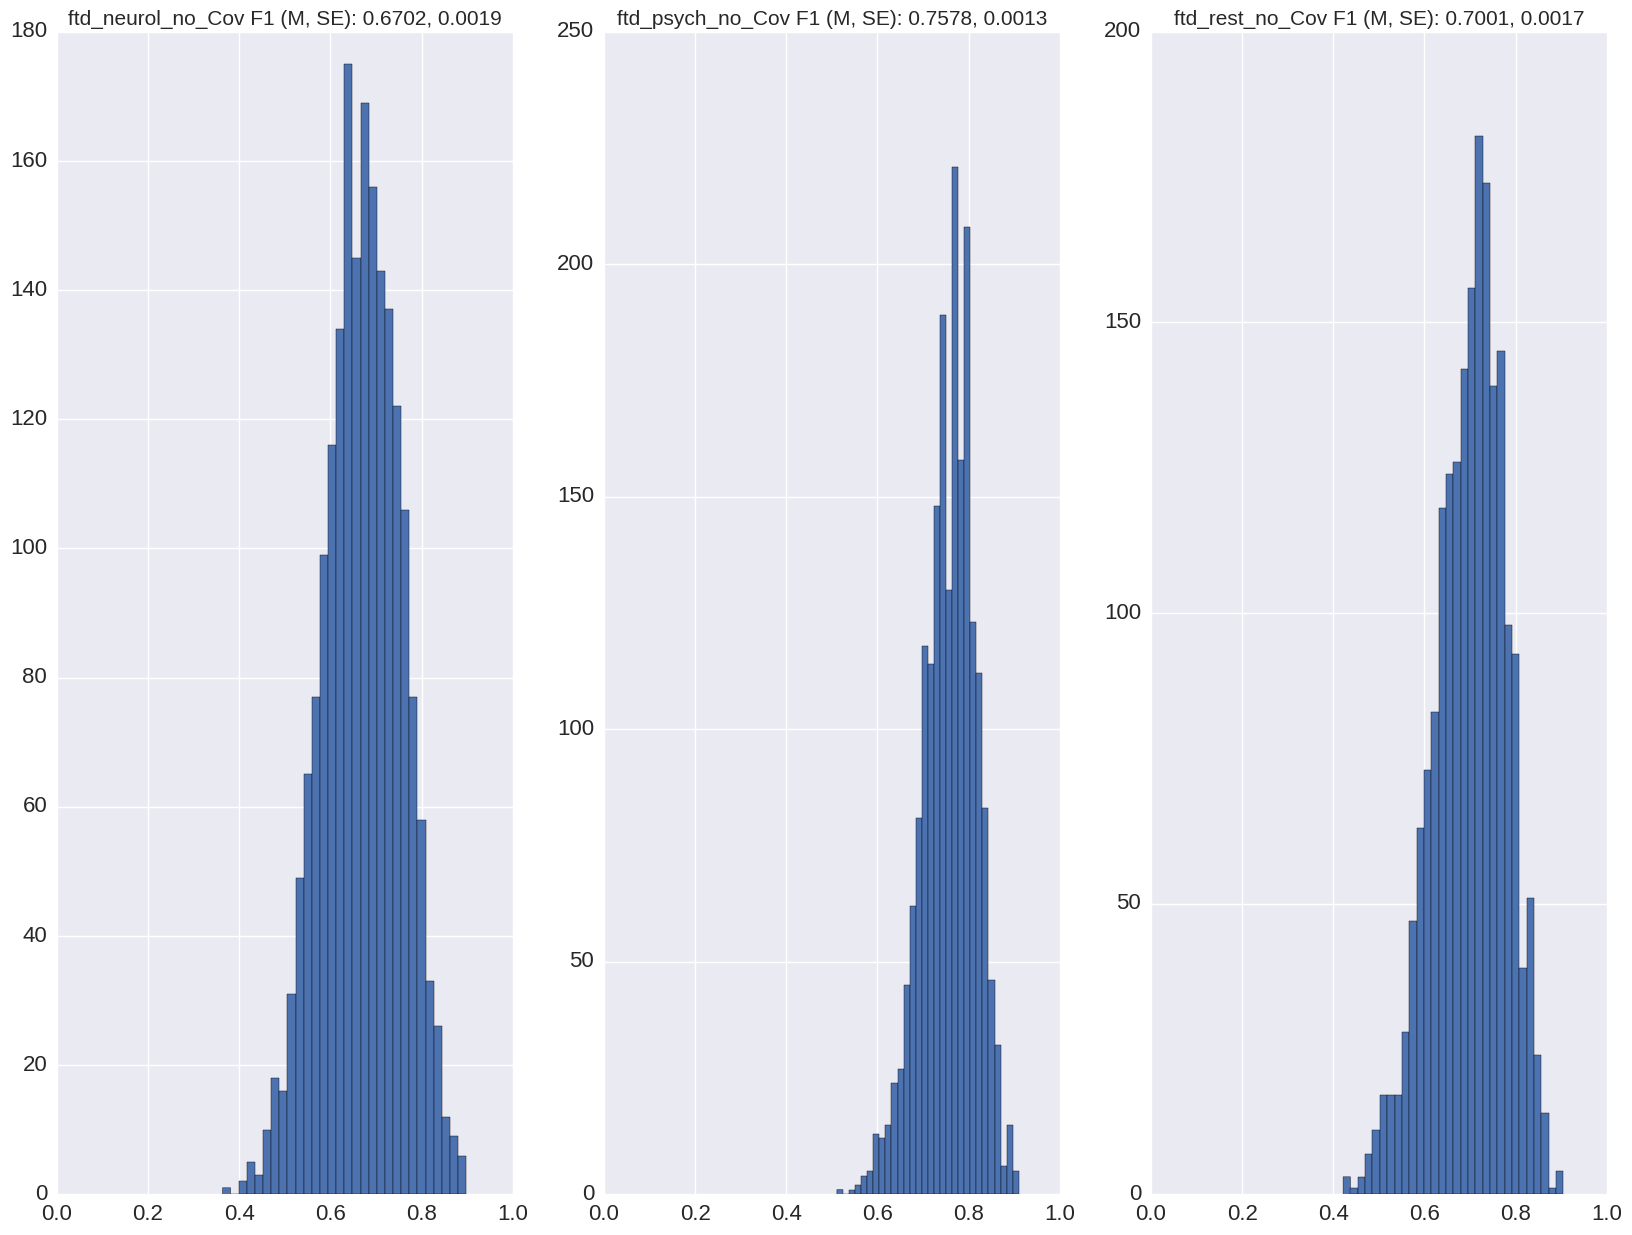

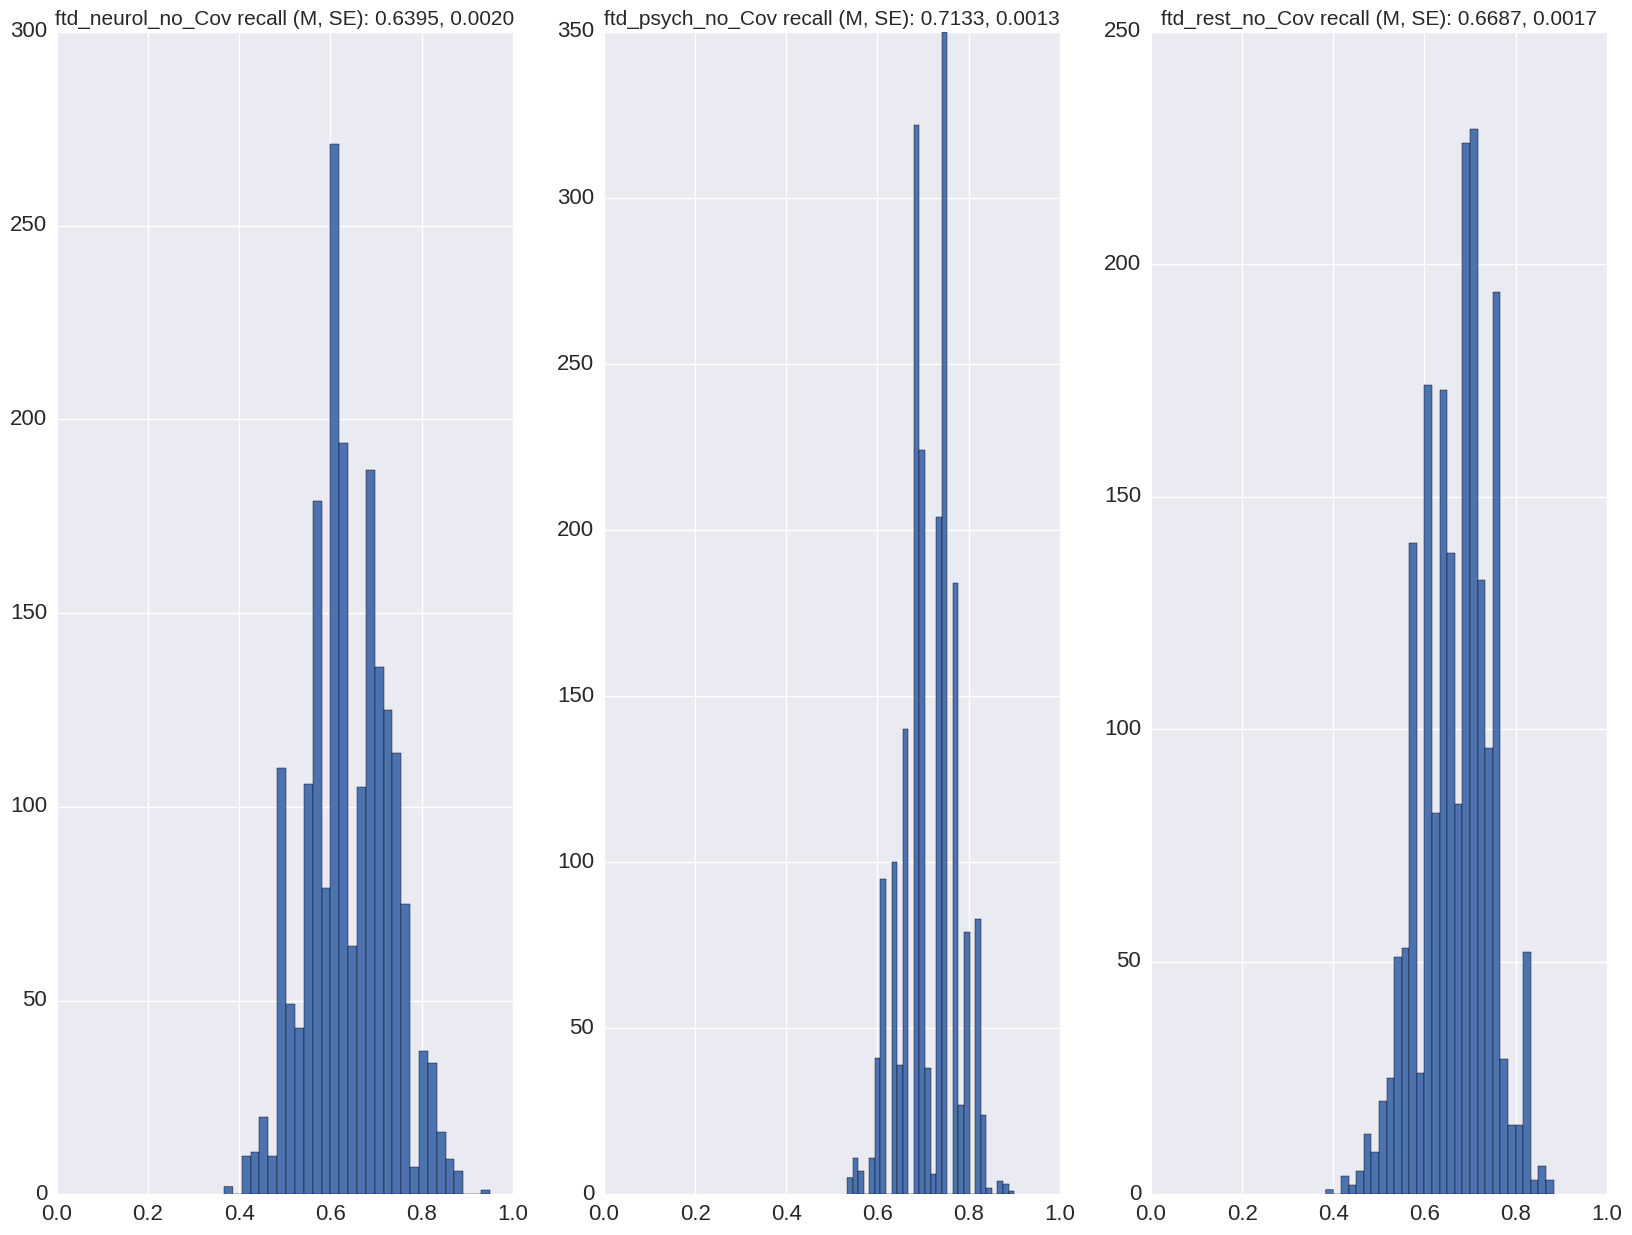

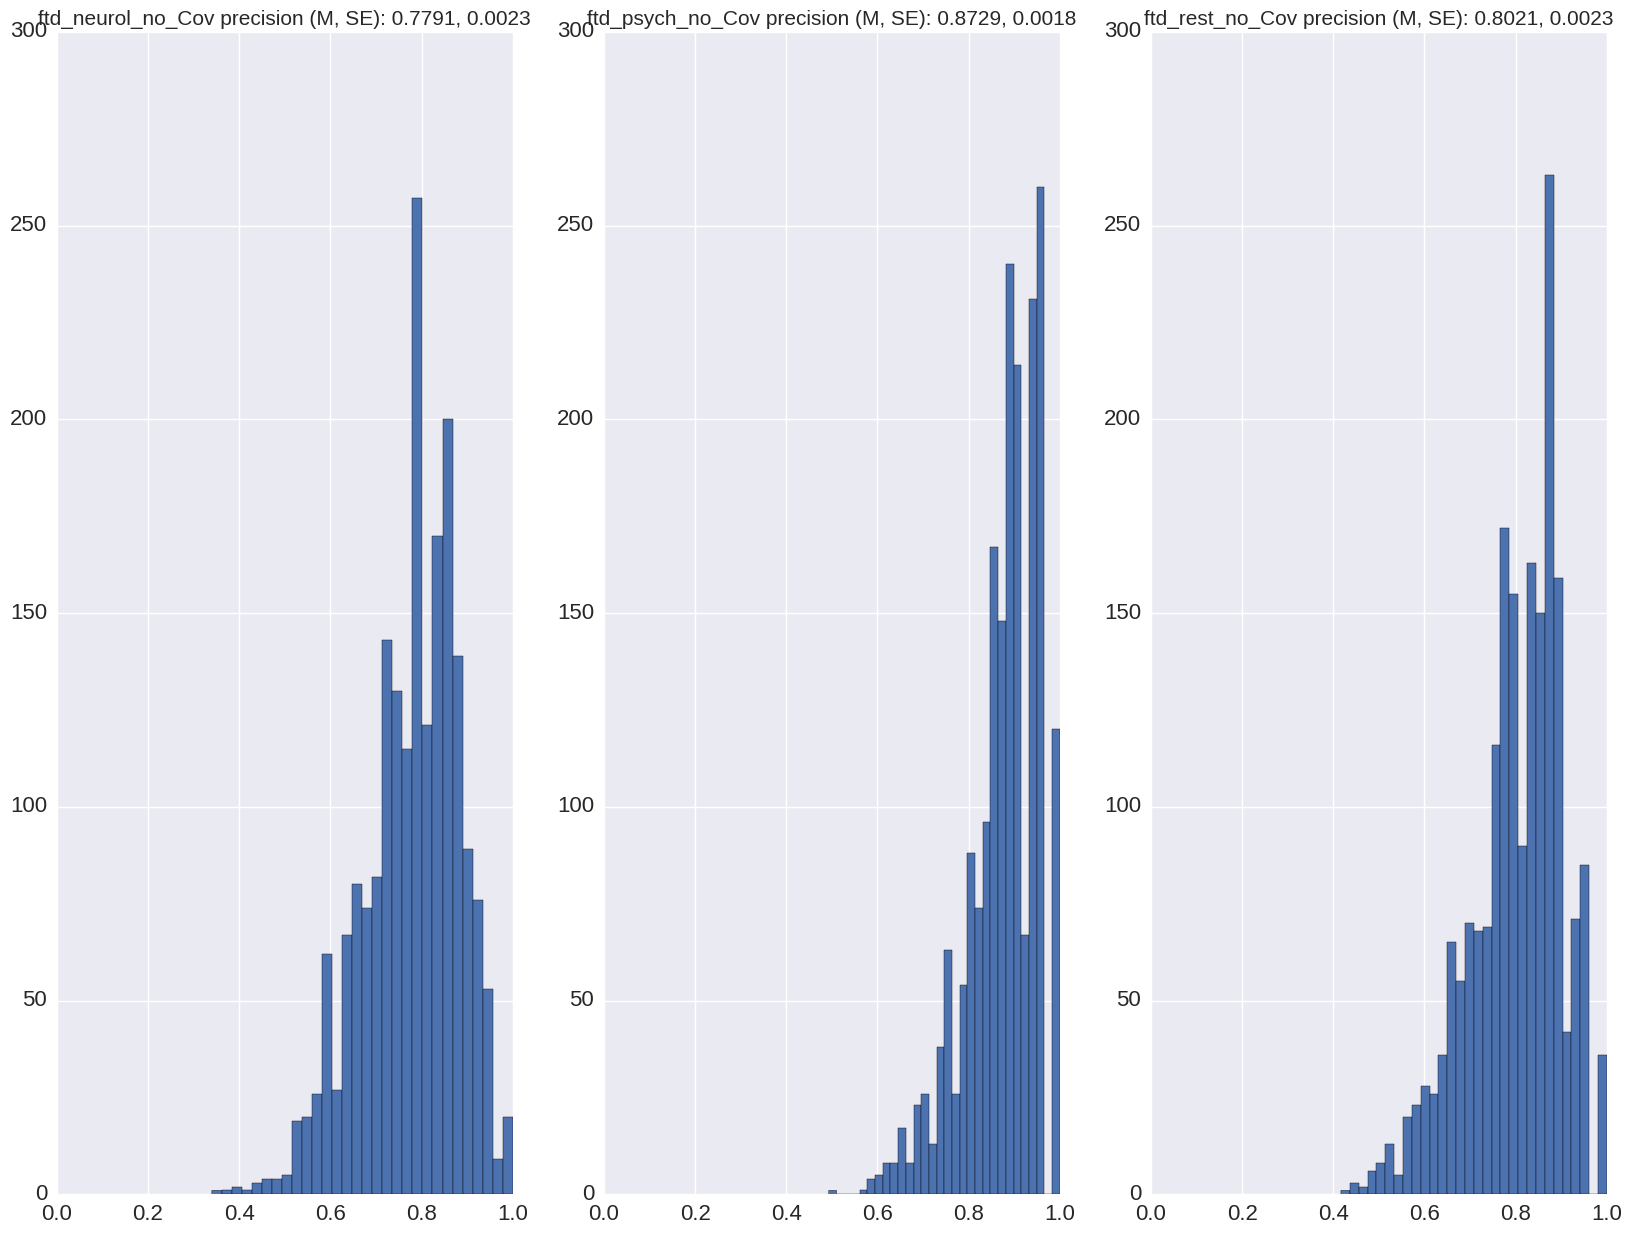

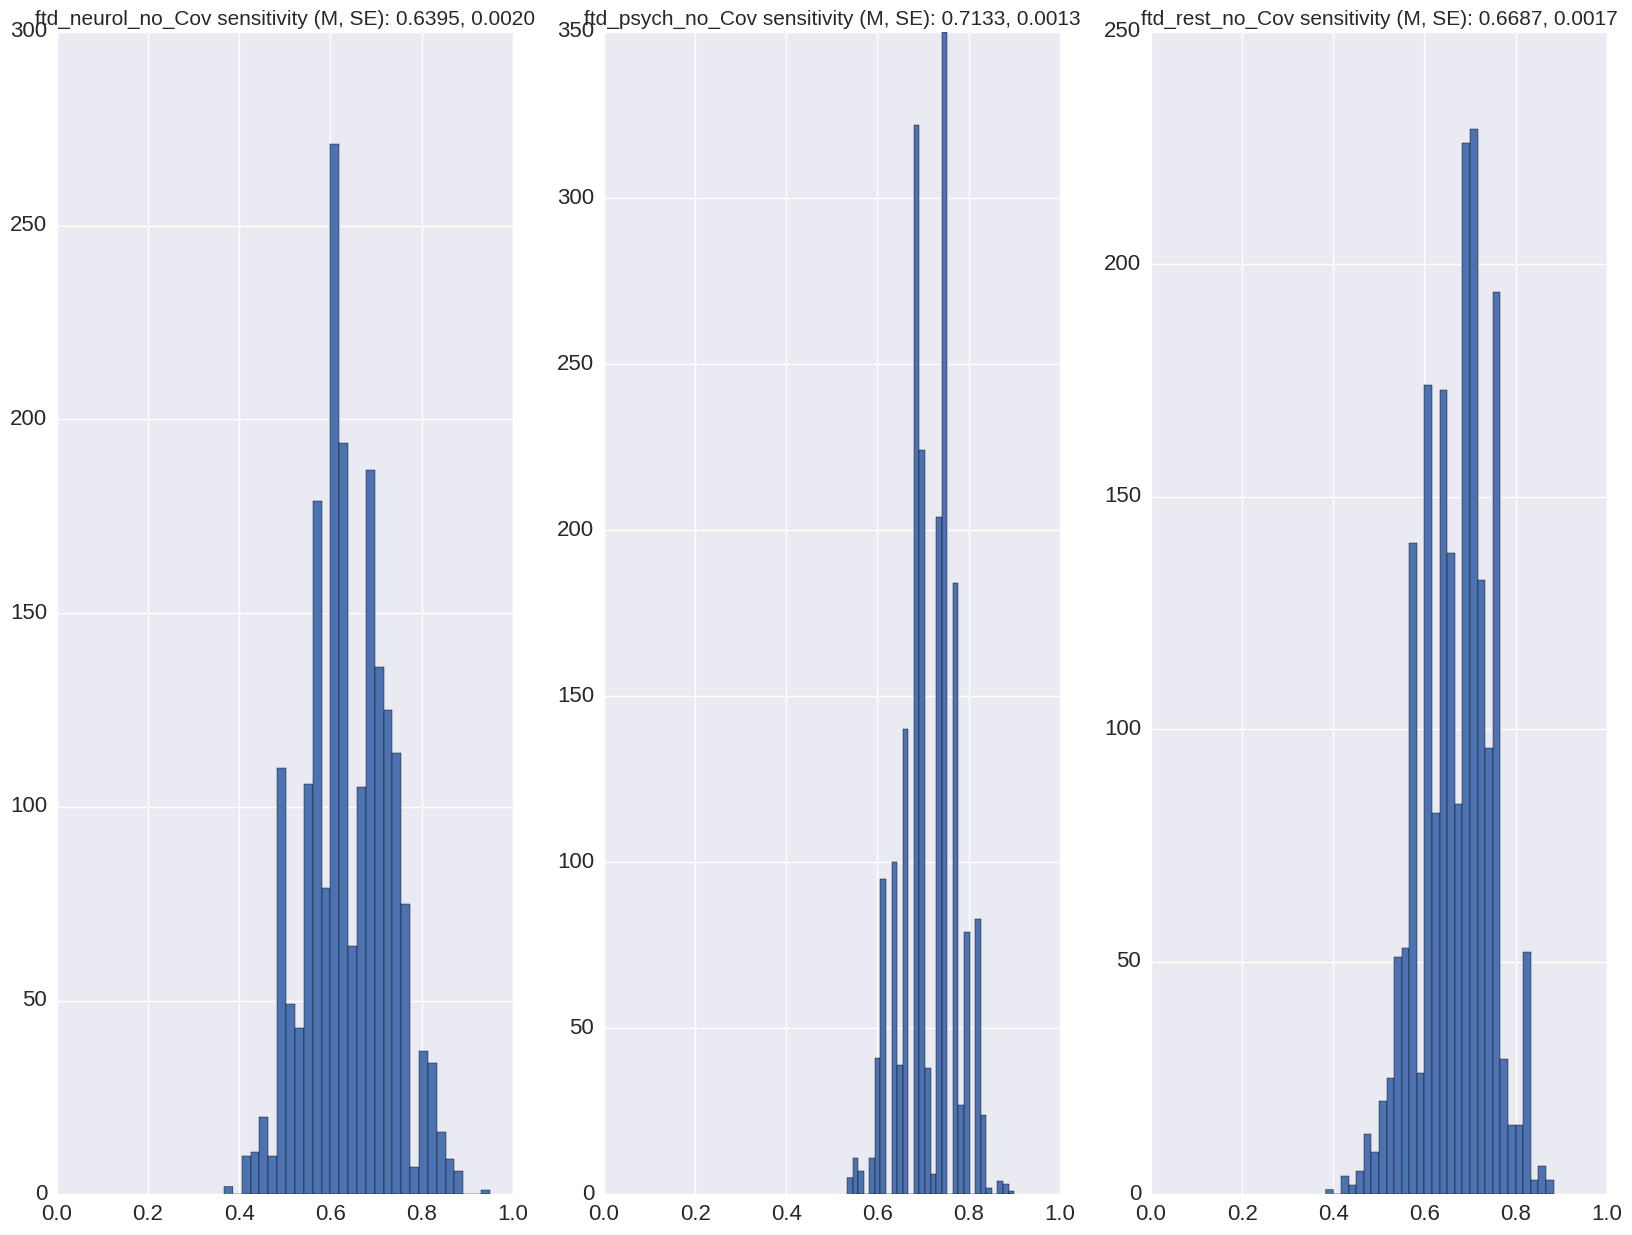

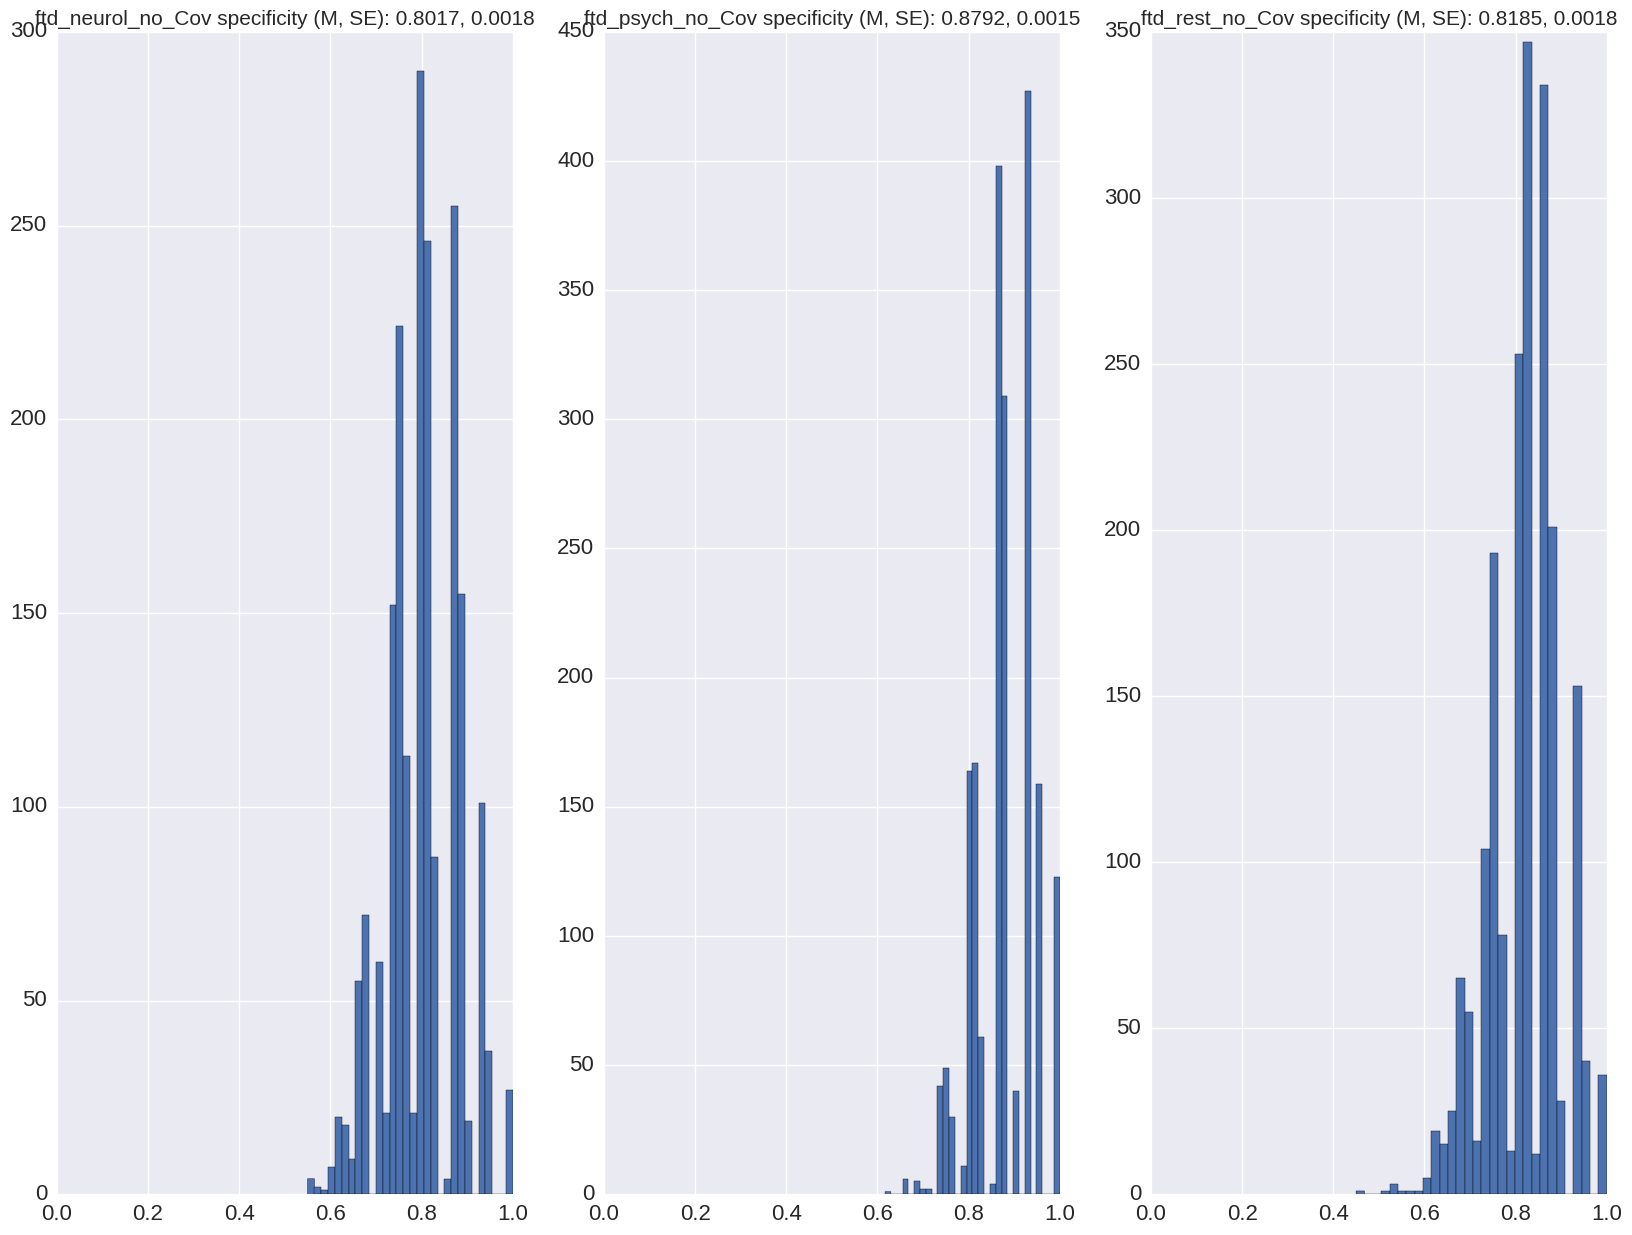

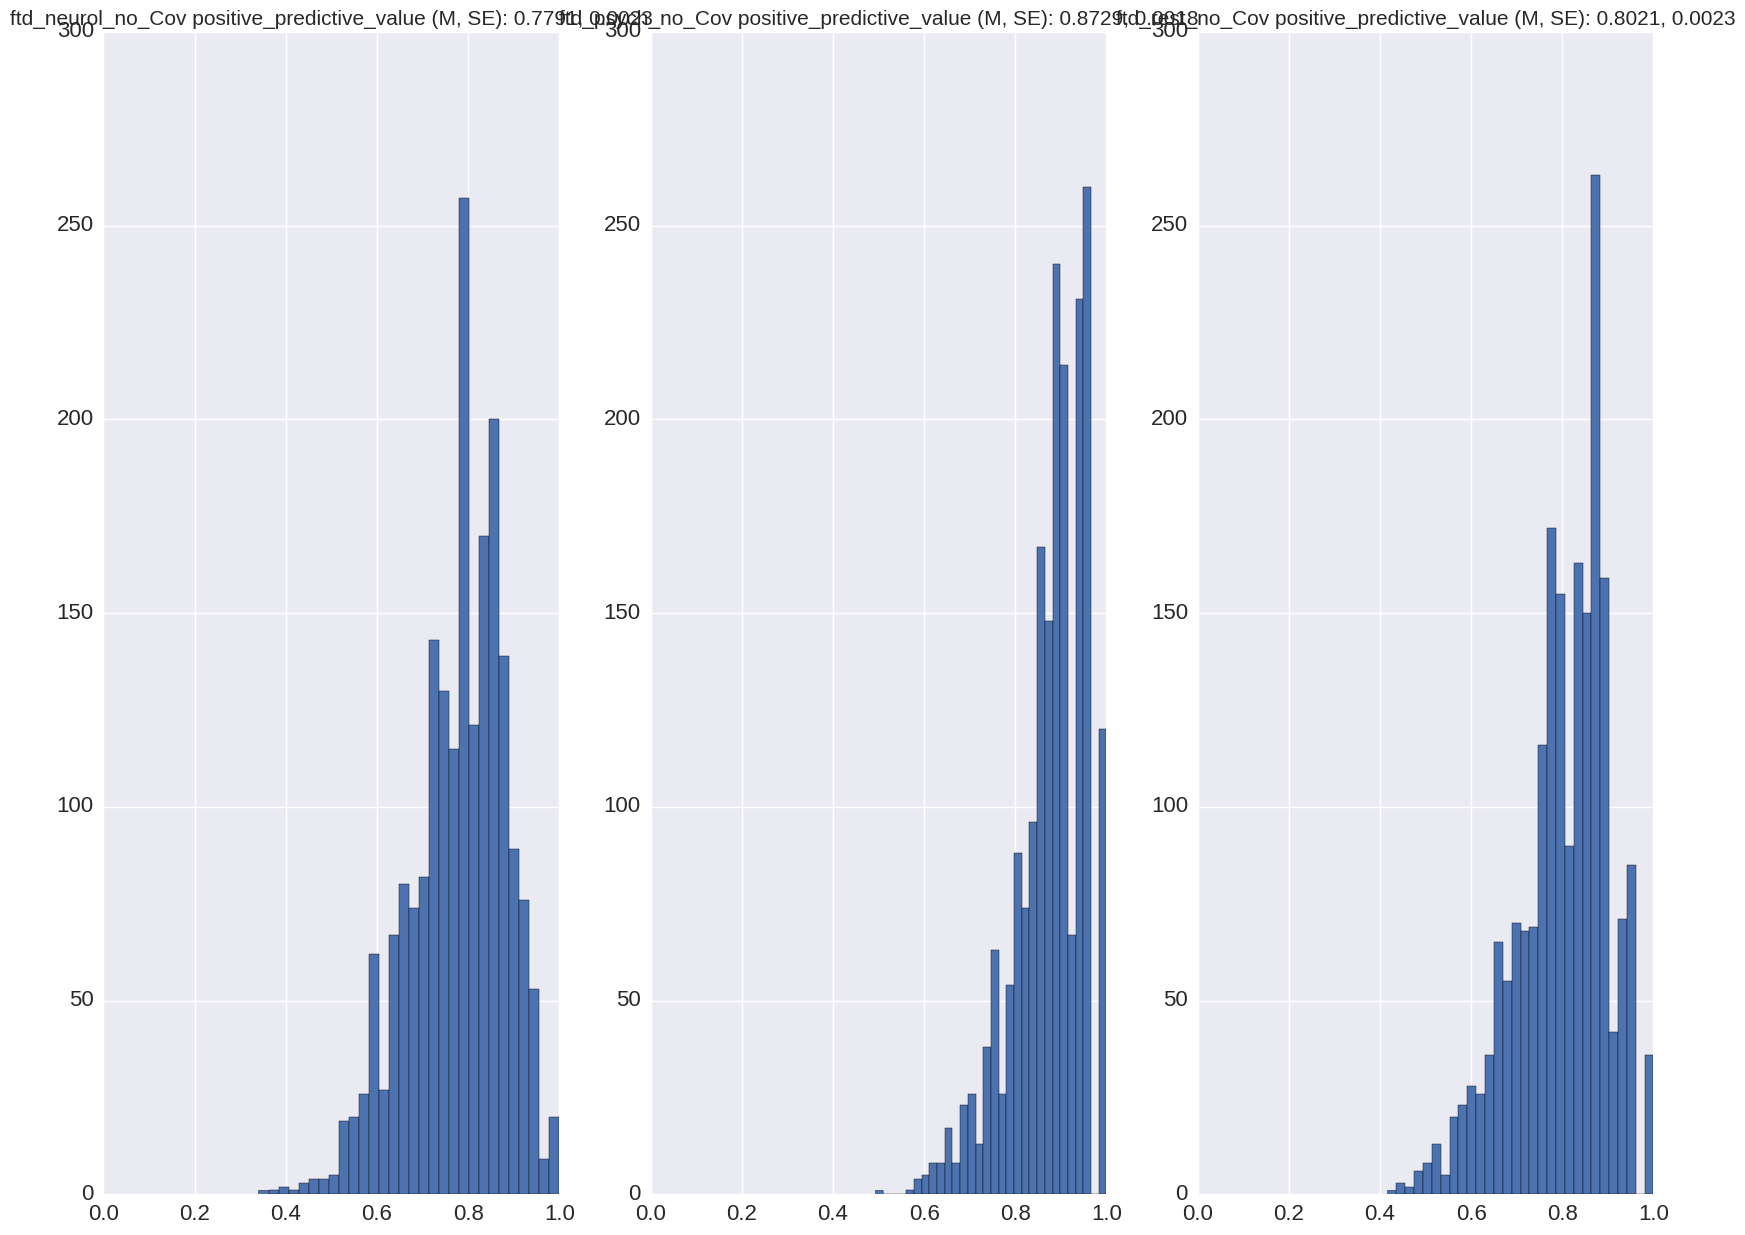

In [57]:
for label in metrics_labels:
    fig, ax = plt.subplots(1, N_RESULTS, sharex=False, figsize=(20, 15))
    ax = ax.ravel()
    for i in xrange(len(RESULTS_FOLDER)):
        tmp = np.load(osp.join(RESULTS_FOLDER[i], 'performance_metrics.npz'))
        metrics = tmp['metrics']
        metrics_labels = tmp['metrics_labels']
        metrics_mean_cv = metrics.mean(axis=0)
        id_accuracy = metrics_labels == label
        ax[i].hist(metrics_mean_cv[:, id_accuracy], bins=30)
        metrics_mean_cv_sampling = metrics_mean_cv.mean(axis=0)
        std_error_cv_sampling = metrics_mean_cv.std(axis=0)/np.sqrt(metrics_mean_cv.shape[0])
        classification = get_last_part_filename(RESULTS_FOLDER[i])
        ax[i].set_title('{} {} (M, SE): {:.4f}, {:.4f}'.format(classification, label,
                                                               metrics_mean_cv_sampling[id_accuracy][0], 
                                                               std_error_cv_sampling[id_accuracy][0]),
                       fontsize=15)
        ax[i].set_xlim([0, 1])
        ax[i].tick_params(axis='both', labelsize=16)